<a href="https://colab.research.google.com/github/matzolla/RICE-DISEASE-CLASSIFICATION/blob/main/Microsoft_Rice_Disease_Classification_Challenge_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install packages
!pip install --upgrade -q fastai

## Import Libraries

In [ ]:
import os
import PIL
import torch
import fastai
import numpy as np 
import torchvision
import pandas as pd
from fastai.vision.all import *

## Load datasets

In [ ]:
path='/content/drive/MyDrive/Colab Notebooks/zindi'
os.listdir(path)

['Train.csv', 'Test.csv', 'SampleSubmission.csv', 'Images.zip']

In [ ]:
# unzip file 
!unzip "/content/drive/MyDrive/Colab Notebooks/zindi/Images.zip" -d 'Images/'


Streaming output truncated to the last 5000 lines.
  inflating: Images/id_c8sl86v71p.jpg  
  inflating: Images/id_c8sl86v71p_rgn.jpg  
  inflating: Images/id_c8zqlaoscm.jpg  
  inflating: Images/id_c8zqlaoscm_rgn.jpg  
  inflating: Images/id_c8zzji9xf7.jpg  
  inflating: Images/id_c8zzji9xf7_rgn.jpg  
  inflating: Images/id_c996aefk2b.jpg  
  inflating: Images/id_c996aefk2b_rgn.jpg  
  inflating: Images/id_ca1ulb7phu.jpg  
  inflating: Images/id_ca1ulb7phu_rgn.jpg  
  inflating: Images/id_cai4ccm9qm.jpg  
  inflating: Images/id_cai4ccm9qm_rgn.jpg  
  inflating: Images/id_carqo16fzo.jpg  
  inflating: Images/id_carqo16fzo_rgn.jpg  
  inflating: Images/id_cawcl2dlbx.jpg  
  inflating: Images/id_cawcl2dlbx_rgn.jpg  
  inflating: Images/id_cb2ltrvv0p.jpg  
  inflating: Images/id_cb2ltrvv0p_rgn.jpg  
  inflating: Images/id_cbeetofpky.jpg  
  inflating: Images/id_cbeetofpky_rgn.jpg  
  inflating: Images/id_cbrq69l0b7.jpg  
  inflating: Images/id_cbrq69l0b7_rgn.jpg  
  inflating: Images/id_cc

In [ ]:
train=pd.read_csv(path+'/Train.csv')
test=pd.read_csv(path+'/Test.csv')

In [ ]:
len(train)

5340

## Data exploration

In [ ]:
# transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((224,224)),
#     torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
# ])

Create the dataloaders

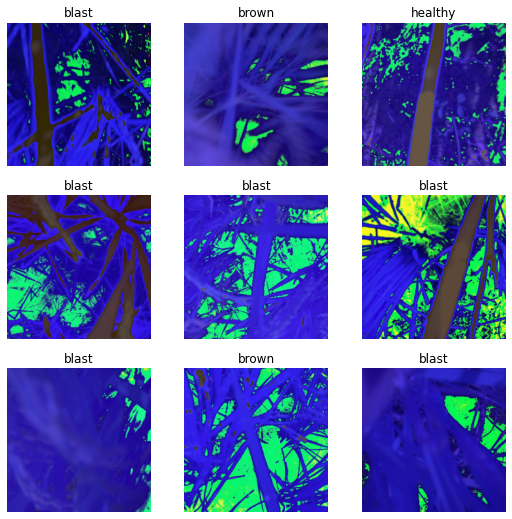

In [ ]:
# train_imr = train[~train.Image_id.str.contains('_rgn')] # Just the RGB images
train_imr = train[train.Image_id.str.contains('_rgn')] # Just the RGN images
dls = ImageDataLoaders.from_df(train_imr, fn_col='Image_id', label_col='Label', 
                               folder='Images', item_tfms=Resize(400),#400
                               batch_tfms = aug_transforms(size=224),#224
                      
                               ) #225
dls.show_batch() # Note the augmentation applied to the images!

## Load the pretrained models

### 1.resnext50

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.656758,1.334789,0.425094,19:45


epoch,train_loss,valid_loss,error_rate,time
0,1.115730,0.874836,0.312734,25:57


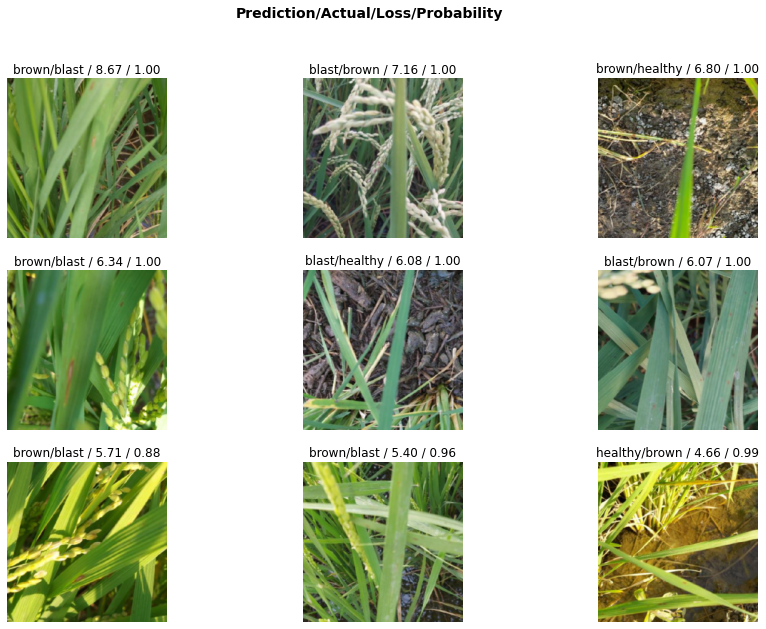

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

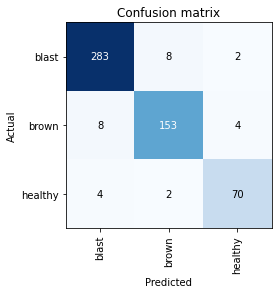

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
#test = pd.read_csv('Test.csv')
test=pd.read_csv(path+'/Test.csv')
test = test[~test.Image_id.str.contains('_rgn')] 
# test = test[test.Image_id.str.contains('_rgn')] # Just the RGB images
preds, _ = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities
preds.shape

torch.Size([1145, 3])

In [ ]:
learn.dls.vocab

['blast', 'brown', 'healthy']

In [ ]:
submission = pd.DataFrame({'Image_id': test['Image_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = preds[:,i].numpy()
submission.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,9.994884e-01,2.984940e-06,5.086248e-04
2,id_01hu05mtch.jpg,3.155822e-07,9.999931e-01,6.507857e-06
4,id_030ln10ewn.jpg,6.542338e-02,2.144906e-01,7.200860e-01
6,id_03z57m8xht.jpg,9.999995e-01,2.207359e-08,5.364042e-07
8,id_04ngep1w4b.jpg,3.602515e-01,6.391288e-01,6.196016e-04


### Submission file

In [ ]:
submission.to_csv('A3submission3.csv', index=False)

In [ ]:
test=pd.read_csv(path+'/Test.csv')
test = test[~test.Image_id.str.contains('_rgn')]
# test = test[test.Image_id.str.contains('_rgn')]
preds, _ = learn.tta(dl=dls.test_dl(test)) # <<<< tta instead of get_preds
submission = pd.DataFrame({'Image_id': test['Image_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = preds[:,i].numpy()
submission.to_csv('A2submission_TTA.csv', index=False)

1. Resnet50:  ~ $0.25$----> $0.22$ with test-time augmentation ----> resize 400, reshape 224 
2. Resnet34:  ~ $0.35$----> $?$ with test-time augmentation ----> resize 400, reshape 224 
3. Resnet50:  ~ $0.17$----> $0.13$ with test-time augmentation ----> resize 400, reshape 225 , epochs=10

4. Resnet50:  ~ $0.18$----> $0.16$ with test-time augmentation ----> resize 400, reshape 225 , epochs=15